In [71]:
import numpy as np, math, copy, matplotlib.pyplot as plt, random, sys
from time import time

sys.setrecursionlimit(10000)

# **Classe Grafo**

In [29]:
# A classe representa a entidade de um grafo com o ponto de partida, 
# vértices, arestas e os pontos turísticos dentre os vértices.

class Graph:
    def __init__(self, *args) -> None:
        self.startingPoint = args[0]
        self.edges = {i.nodeName:i.edgeList for i in args}
        self.nodes, self.touristicPoints = args, [i for i in args if i.isTouristic]
        
    def __str__(self):
        return f"Nodes: {len(self.nodes)} | Touristic points: {len(self.touristicPoints)}"

# **Classe vértice**

In [7]:
# Classe que representa um vértice com os dados de cada nó, 
# utilizados nos algoritmos de busca.

class Node:
    def __init__(self, nodeName, xCoord, yCoord, timeSpent = 0, isTouristic =  False, edgeList = None, pastNodes = None) -> None:
        self.nodeName = nodeName
        self.xCoord, self.yCoord = xCoord, yCoord
        self.timeSpent = timeSpent
        self.isTouristic = isTouristic
        self.isVisited = False
        self.pastNodes = pastNodes if pastNodes != None else []
        self.edgeList = edgeList if edgeList != None else {}
        self.realPath = {}
        
    def __repr__(self) -> str:
        return f"\"{self.nodeName}\" at ({self.xCoord}, {self.yCoord})"
    
    def addEdges(self, *args):
        self.edgeList.update({i[0] if isinstance(i, tuple) else 
                              i: i[1] if isinstance(i, tuple) else 1 for i in args})
        
    def getEuclideanDistance(self, other) -> float:
        return math.sqrt((self.xCoord - other.xCoord)**2 + (self.yCoord - other.yCoord)**2)
    
    def getGraphDistance(self, other) -> float:
        if self is other:
            return 0
        
        return self.edgeList.get(other, np.inf)

## Funções gerais do grafo

In [91]:
# Gera um grafo aleatório com um número "n" de vértices.
def randomGraph(n, xLowerLimit = -100.0, xUpperLimit = 100.0, yLowerLimit = -100.0, yUpperLimit = 100.0):
    nodes = [Node(f"Start", random.uniform(xLowerLimit, xUpperLimit), random.uniform(yLowerLimit, yUpperLimit))]
    
    for i in range(n):
        x = random.uniform(xLowerLimit, xUpperLimit)  # Coordenadas como números flutuantes
        y = random.uniform(yLowerLimit, yUpperLimit)
        nodes.append(Node(f"Node{i}", x, y, isTouristic = random.random() < 0.4))
        
    minEdge, maxEdge = n // 4, n // 2

    # Adicionando arestas com pesos aleatórios
    for node in nodes:
        possible_edges = [n for n in nodes if n != node and n not in [e[0] for e in node.edgeList]]
        number_of_edges = np.random.randint(minEdge, maxEdge)
        for edge_node in random.sample(possible_edges, number_of_edges):
            weight = random.uniform(1.0, node.getEuclideanDistance(edge_node) // 3)
            node.addEdges((edge_node, weight))

    return Graph(*nodes)

# Plota os pontos de um grafo.
def plotGraphPoints(graph):
    plt.figure(figsize=(5, 4))
    ax = plt.gca()

    for point in graph.nodes:
        for edgePoint in point.edgeList:
            plt.annotate(
                '', 
                xy=(edgePoint.xCoord, edgePoint.yCoord), 
                xytext=(point.xCoord, point.yCoord),
                arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->', linewidth=0.7)
            )

        if point == graph.startingPoint:
            plt.plot(point.xCoord, point.yCoord, 'go', markersize=10, label='Starting Point' if point == graph.startingPoint else "")  # Verde para o ponto inicial
        else:
            plt.plot(point.xCoord, point.yCoord, 'rs' if point.isTouristic else 'ko', markersize=8, label='Touristic' if point.isTouristic else "Non-Touristic")

        ax.annotate(
            f'{point.nodeName}', 
            (point.xCoord, point.yCoord), 
            textcoords="offset points", 
            xytext=(12,-12), 
            ha='center'
        )

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.show()
    
# Imprime o resultado final de uma busca.
def printFinalPath(bestPath):
    print(" -> ".join(bestPath[0]), f"| Pontos visistados: {bestPath[1]} | Custo: {bestPath[2]}")

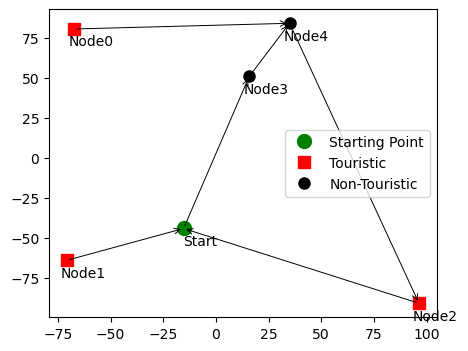

In [19]:
plotGraphPoints(randomGraph(5))

## Funções da busca cega

In [23]:
# Performa a busca cega recursiva.
def recursiveBlindSearch(graph, currentNode, timeLimit, finalPaths, pointsVisited):
    # Caso todos os pontos turísticos já tenham sido visitados e o nó atual é o nó inicial, pare a recursão.
    if pointsVisited == len(graph.touristicPoints) and currentNode.nodeName == graph.startingPoint.nodeName:
        finalPaths.append(([i.nodeName for  i in currentNode.pastNodes + [currentNode]], pointsVisited, timeLimit))
        return
    
    # Para cada nó ligado ao nó atual, faça uma recursão de busca de soluções.
    for node in currentNode.edgeList.keys():
        if currentNode.getGraphDistance(node) <= timeLimit:
            recursiveBlindSearch(graph, Node(node.nodeName, node.xCoord, node.yCoord, 
                                      pastNodes = currentNode.pastNodes + [currentNode], edgeList = node.edgeList), 
                                      timeLimit - currentNode.getGraphDistance(node), finalPaths,
                                      pointsVisited + 1 if node.isTouristic 
                                      and node.nodeName not in [i.nodeName for i in currentNode.pastNodes] else pointsVisited)
            
        # Caso o nó atual seja o nó inicial, foi completado um ciclo em torno do ponto inicial,
        # então adicione ao vetor de soluções factíveis.
        if currentNode.nodeName == graph.startingPoint.nodeName and currentNode.pastNodes + [currentNode] not in finalPaths:
            finalPaths.append(([i.nodeName for  i in currentNode.pastNodes + [currentNode]], pointsVisited, timeLimit))

# Realize a busca cega.
def blindSearch(graph, timeLimit):
    recursiveBlindSearch(graph, graph.startingPoint, timeLimit, finalPathsList := [], 0)

    bestPath = max(finalPathsList, key = lambda x: (x[1], x[2]))
    
    return (bestPath[0], bestPath[1], timeLimit - bestPath[2])

Nodes: 51 | Touristic points: 17
Start -> Node38 -> Node37 -> Node49 -> Node44 -> Node40 -> Node42 -> Node28 -> Node41 -> Node35 -> Start | Pontos visistados: 4 | Custo: 18.738598139503857
1.429142951965332


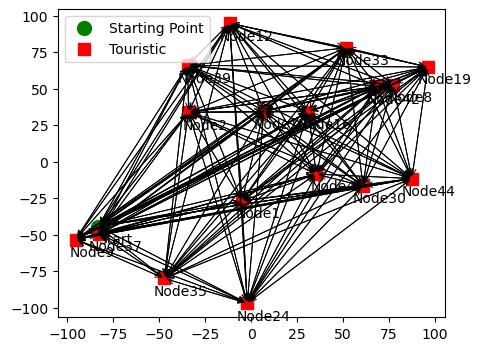

In [83]:
blindGraph = randomGraph(50)

print(blindGraph)

start = time()

printFinalPath(blindSearch(blindGraph, 20))

print(time() - start)

plotGraphPoints(reduceGraph(blindGraph))

## Funções da busca heurística

In [36]:
# Redução do Grafo a apenas pontos turísticos
def reduceGraph(originalGraph):
    touristicPointsCopy = copy.deepcopy([originalGraph.startingPoint] + originalGraph.touristicPoints)
    
    for i in touristicPointsCopy:
        shortestPathList = {node : shortPath for node in touristicPointsCopy if i != node and 
                            (shortPath := shortestPath(originalGraph, euclideanHeuristic, i, node))[1] != np.inf}
        
        i.edgeList = {a:  b[1] for a, b in shortestPathList.items()}
        i.realPath = {a : b[0][1:] for a, b in shortestPathList.items()}
                
    return Graph(*touristicPointsCopy)

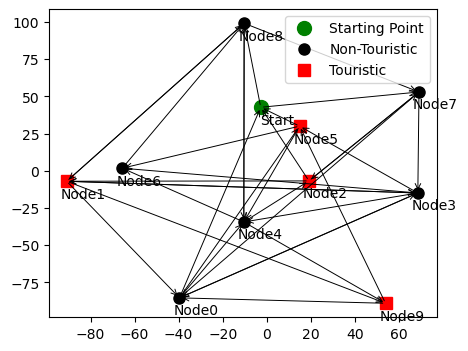

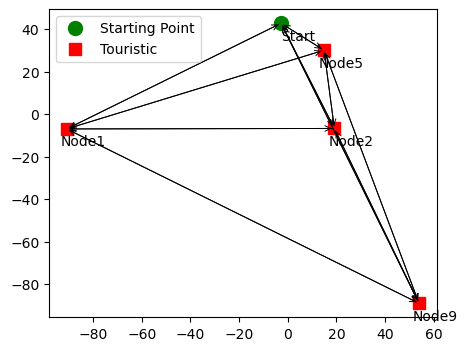

In [104]:
randGraph = randomGraph(10)

plotGraphPoints(randGraph)

plotGraphPoints(reduceGraph(randGraph))

In [37]:
# Heurística de distância euclidiana
def euclideanHeuristic(originNode, destinyNode):
    return originNode.getEuclideanDistance(destinyNode)   

# Algoritmo do A*
def shortestPath(graph, heuristic, originNode, destinyNode):
    if originNode == destinyNode:
        return originNode, 0, 1
    
    openNodes, closedNodes = [], set()

    currentNode = (Node(originNode.nodeName, originNode.xCoord, originNode.yCoord), 0, heuristic(originNode, destinyNode))
    
    openNodes.append(currentNode)

    # Enquanto houverem nós abertos continue a busca a solução    
    while openNodes:
        closedNodes.add(currentNode[0].nodeName)
        
        # Caso o nó destino seja atingido, pare a recursão e retorne a rota
        if currentNode[0].nodeName == destinyNode.nodeName:
            return currentNode[0].pastNodes + [currentNode[0]], currentNode[1]
        
        # Escolha, dentre os nós abertos, o que possui menor função de custo
        
        currentNeighbors = graph.edges[currentNode[0].nodeName]
        
        openNodes.extend([(Node(i.nodeName, i.xCoord, i.yCoord, pastNodes = currentNode[0].pastNodes + [currentNode[0]], timeSpent = j + currentNode[0].timeSpent), 
        j + currentNode[0].timeSpent, heuristic(i, destinyNode)) for i, j in currentNeighbors.items() if i.nodeName not in closedNodes])
        
        tmpNode = min(openNodes, key = lambda x:(x[1] + x[2]))
        
        if currentNode in openNodes:
            openNodes.remove(currentNode)

        currentNode = tmpNode
        
    # Caso não exista uma rota ligando os nós, retorne None
    return None, np.inf

In [82]:
# Função para encontrar melhor rota
def maxPointsPath(reducedGraph, timeLimit):
    startPoint = reducedGraph.startingPoint
    
    finalPath, currentNode = [startPoint.nodeName], startPoint
    timeSpent = pointsVisited = 0
        
    # Enquanto houverem nós que são candidatos a nós futuros, percorra o grafo
    while (avaiable := [(i, j) for i, j in currentNode.edgeList.items() if not i.isVisited and i != startPoint
                        and j + timeSpent + i.getGraphDistance(startPoint) <= timeLimit]):
        
        # Selecione o mínimo dentro os nós possíveis
        currentEdge = min(avaiable, key = lambda x: x[1])
        
        timeSpent += currentEdge[1]
        
        finalPath.extend(i.nodeName for i in currentNode.realPath.get(currentEdge[0]))
        
        currentNode = currentEdge[0]
        
        currentNode.isVisited = True
        
        pointsVisited += 1

    return (finalPath + [i.nodeName for i in currentNode.realPath.get(startPoint, [])], 
            pointsVisited, timeSpent + currentNode.getGraphDistance(startPoint))

In [81]:
graph = randomGraph(250)

print(graph)

start = time()

printFinalPath(maxPointsPath(reduceGraph(graph), 500))

print(time() - start)

Nodes: 251 | Touristic points: 89
Start -> Node178 -> Node54 -> Node70 -> Node119 -> Node206 -> Node158 -> Node114 -> Node102 -> Node103 -> Node73 -> Node43 -> Node159 -> Node13 -> Node58 -> Node229 -> Node53 -> Node55 -> Node50 -> Node115 -> Node131 -> Node235 -> Node204 -> Node83 -> Node224 -> Node49 -> Node0 -> Node173 -> Node15 -> Node63 -> Node209 -> Node28 -> Node110 -> Node175 -> Node92 -> Node205 -> Node86 -> Node242 -> Node181 -> Node18 -> Node105 -> Node31 -> Node227 -> Node23 -> Node217 -> Node201 -> Node236 -> Node101 -> Node223 -> Node87 -> Node141 -> Node84 -> Node139 -> Node113 -> Node104 -> Node212 -> Node230 -> Node20 -> Node95 -> Node187 -> Node183 -> Node76 -> Node19 -> Node33 -> Node66 -> Node9 -> Node17 -> Node16 -> Node30 -> Node124 -> Node214 -> Node98 -> Node213 -> Node116 -> Node145 -> Node193 -> Node127 -> Node171 -> Node104 -> Node96 -> Node3 -> Node91 -> Node202 -> Node107 -> Node197 -> Node12 -> Node123 -> Node46 -> Node209 -> Node55 -> Node218 -> Node74 ->